## Introducción

Entrenamiento de modelo preentrenado para resolver el problema de predecir el ángulo del auto en base a la imagen.

Fuertemente basado en:
- https://towardsdatascience.com/a-practical-example-in-transfer-learning-with-pytorch-846bb835f2db
- https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html 

## Imports

In [1]:
import torch
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
from torchmetrics import MetricCollection, Accuracy, Precision, Recall, F1, ConfusionMatrix
import pandas as pd
import sklearn
from torch.utils.tensorboard import SummaryWriter

from datetime import datetime
import os

import importlib
import training_helper
from dataset_modules.angle_dataset import AngleDataset
import metrics_helper

importlib.reload(training_helper)
importlib.reload(metrics_helper)

<module 'metrics_helper' from '/Users/lbarenchi/Documents/Facultad/Tesis/tesis-jupyters/metrics_helper.py'>

## Variables

In [198]:
MODEL_NAME = "angle_model"
EXPERIMENT_NAME = "alexnet_feature_extraction"
FEATURE_EXTRACTION = True

device_string = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device_string)

if device_string == "cuda":
    print("Usando GPU!")

In [199]:
os.makedirs("./trained_models/{}/{}".format(MODEL_NAME, EXPERIMENT_NAME), exist_ok=True)

## Dataset

Se crea un dataset de tipo `ImageFolder` que se toma de la carpeta `dataset`, donde cada subcarpeta es una de las categorías a entrenar. 

Automáticamente mapea categorías a números `dataset.class_to_idx`.

Finalmente se hace el split en train y test en 80/20.

In [200]:
dataset = AngleDataset(
    transform=transforms.Compose([
        transforms.ColorJitter(0.1, 0.1, 0.1, 0.1),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
)

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [len(dataset) - 100, 100])
classes = dataset.classes
dataset_sizes = {
    'train': len(train_dataset),
    'test': len(test_dataset)
}

----- CLASS DISTRIBUTION -----
Class: atras_acomp, #117, 23.35%
Class: atras_cond, #111, 22.16%
Class: frente_acomp, #108, 21.56%
Class: frente_cond, #104, 20.76%
Class: frente, #23, 4.59%
Class: atras, #20, 3.99%
Class: lado_cond, #11, 2.20%
Class: lado_acomp, #7, 1.40%


In [201]:
dataset[0]

(tensor([[[-1.6727, -1.5528, -1.7412,  ..., -1.2617, -1.2445, -1.3302],
          [-1.6555, -1.5528, -1.7583,  ..., -1.2959, -1.2445, -1.3130],
          [-1.6384, -1.5014, -1.7069,  ..., -1.2959, -1.2617, -1.2617],
          ...,
          [-1.5185, -1.5870, -1.4500,  ...,  0.7419,  0.7248,  0.6221],
          [-1.5699, -1.4843, -1.5699,  ...,  0.6221,  0.6906,  0.7077],
          [-1.5014, -1.5185, -1.5699,  ...,  0.5707,  0.5364,  0.5364]],
 
         [[-1.6681, -1.5280, -1.7206,  ..., -1.2479, -1.2829, -1.4055],
          [-1.6506, -1.5280, -1.7206,  ..., -1.2829, -1.3004, -1.3880],
          [-1.6155, -1.4755, -1.6856,  ..., -1.3004, -1.3004, -1.3354],
          ...,
          [-1.1954, -1.2829, -1.1604,  ...,  0.6954,  0.6604,  0.5553],
          [-1.2479, -1.1954, -1.3179,  ...,  0.5553,  0.6429,  0.6779],
          [-1.1779, -1.2479, -1.3880,  ...,  0.5028,  0.4678,  0.4853]],
 
         [[-1.7347, -1.6127, -1.6650,  ..., -1.3339, -1.3513, -1.4559],
          [-1.7173, -1.6127,

In [202]:
dataset.classes

['atras',
 'atras_acomp',
 'atras_cond',
 'frente',
 'frente_acomp',
 'frente_cond',
 'lado_acomp',
 'lado_cond']

## Loaders
Luego, se crean loaders para cada uno de los conjuntos. Los loaders permiten procesar los datos de a batches.

In [203]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=4
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=4
)

dataloaders = {
    'train': train_loader,
    'test': test_loader
}

## Entrenamiento

En este step se carga el modelo pre-entrenado. Para este ejemplo se utiliza el modelo alexnet por su simplicidad.

#### ¿Finetuning o Feature extraction?

- **Finetuning:** Consiste en incializar la red con los pesos pre-entrenados, y re-entrenar toda la red (ajustar los parámetros de todas las capas) con el dataset custom.
- **Feature extraction:** La diferencia con lo anterior es que se congelan las capas convolucionales, de modo que el entrenamiento no las cambie con nuestros datos.

En ambos casos pisamos la capa de **clasificador** por una capa nueva con 8 categorías, porque el modelo pre-entrenado tiene 1000 labels.

In [204]:
model = models.alexnet(pretrained=True)

NUM_CLASSES = len(classes)

if FEATURE_EXTRACTION:
    for param in model.parameters():
        param.requires_grad = False

model.classifier[6] = torch.nn.Linear(model.classifier[6].in_features, NUM_CLASSES)
model = model.to(device)

# Tensorboard metrics writer
writer = SummaryWriter(log_dir='./trained_models/{}/tensorboard/{}'.format(MODEL_NAME, EXPERIMENT_NAME + '-' + datetime.now().strftime("%Y%m%d-%H%M%S")))

# Función de error
criterion = F.cross_entropy

# Optimizador
parameters_to_update = model.parameters()

if FEATURE_EXTRACTION:
    parameters_to_update = model.classifier[6].parameters()

optimizer = optim.SGD(parameters_to_update, lr=0.001, momentum=0.9)
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [205]:
model = training_helper.train_model(
    model, 
    criterion, 
    optimizer, 
    dataloaders, 
    dataset_sizes, 
    device, 
    writer, 
    NUM_CLASSES,
    'trained_models/{}/{}'.format(MODEL_NAME, EXPERIMENT_NAME),
    main_metric='macro_f1', 
    num_epochs=25
)

Epoch 0/24
----------
train Loss: 1.9448 Main metric (macro_f1): 0.1899 Time: 46.13s
------------------------- GENERAL METRICS -------------------------

Loss 1.9447643162306407
Micro Accuracy 0.2942643463611603
Macro Accuracy 0.18987734615802765
Macro Precision 0.18682266771793365
Macro Recall 0.18987734615802765
Macro F1 0.18987734615802765

test Loss: 1.8584 Main metric (macro_f1): 0.2565 Time: 29.95s
------------------------- GENERAL METRICS -------------------------

Loss 1.8583524274826049
Micro Accuracy 0.3199999928474426
Macro Accuracy 0.2564754784107208
Macro Precision 0.2770833373069763
Macro Recall 0.2564754784107208
Macro F1 0.2564754784107208


Epoch 1/24
----------
train Loss: 2.0085 Main metric (macro_f1): 0.4058 Time: 50.45s
------------------------- GENERAL METRICS -------------------------

Loss 2.008477783113941
Micro Accuracy 0.4887780547142029
Macro Accuracy 0.4058207869529724
Macro Precision 0.4400181770324707
Macro Recall 0.4058207869529724
Macro F1 0.40582078695

In [206]:
BEST_MODEL_PATH = './trained_models/{}/{}/best_model.pth'.format(MODEL_NAME, EXPERIMENT_NAME)
os.makedirs(os.path.dirname(BEST_MODEL_PATH), exist_ok=True)
torch.save(model.state_dict(), BEST_MODEL_PATH)

## Evaluación final

In [207]:
from dataset_modules.common import pil_loader
model.load_state_dict(torch.load(BEST_MODEL_PATH))
model.eval()

metrics = metrics_helper.init_metrics(device, NUM_CLASSES)
tensorboard_transforms = transforms.Compose([
    transforms.ToTensor()
])

total_loss = 0.0

for i, (images, labels, imgs_path) in enumerate(test_loader):
    images = images.to(device)
    labels = labels.to(device)
    
    with torch.no_grad():
        outputs = model(images)
        metrics(outputs, labels)
        
        predictions = torch.argmax(outputs, dim=1)
        loss = criterion(outputs, labels)
        
        total_loss += loss.item() * images.size(0)
        
        for sampleno in range(images.shape[0]):
            if(labels[sampleno] != predictions[sampleno]):
                name = 'Misclasified_Predicted-{}_Classified-{}/{}'.format(classes[predictions[sampleno]], classes[labels[sampleno]], imgs_path[sampleno])
                
                writer.add_image(name, tensorboard_transforms(pil_loader('./dataset_modules/imgs/' + imgs_path[sampleno])))
                writer.flush()
        
total_loss /= dataset_sizes["test"]

metrics_result = metrics.compute()

In [208]:
macro_metrics = metrics_helper.generate_macro_metrics(metrics_result, total_loss)
per_class_metrics = metrics_helper.generate_per_class_metrics(metrics_result, classes)

macro_metrics.to_csv('./trained_models/{}/{}/best_model_macro_metrics.csv'.format(MODEL_NAME, EXPERIMENT_NAME), index=False)
per_class_metrics.to_csv('./trained_models/{}/{}/best_model_per_class_metrics.csv'.format(MODEL_NAME, EXPERIMENT_NAME), index=False)

------------------------- GENERAL METRICS -------------------------

Loss 1.5377152919769288
Micro Accuracy 0.5600000023841858
Macro Accuracy 0.6322691440582275
Macro Precision 0.5550770163536072
Macro Recall 0.6322691440582275
Macro F1 0.6322691440582275

------------------------- PER CLASS METRICS -------------------------


,class,accuracy,precision,recall,f1
0,atras,1.000000,0.666667,1.000000,1.000000
1,atras_acomp,0.766667,0.547619,0.766667,0.766667
2,atras_cond,0.190476,0.400000,0.190476,0.190476
3,frente,1.000000,0.666667,1.000000,1.000000
4,frente_acomp,0.555556,0.588235,0.555556,0.555556
5,frente_cond,0.545455,0.571429,0.545455,0.545455
6,lado_acomp,1.000000,1.000000,1.000000,1.000000
7,lado_cond,0.000000,0.000000,0.000000,0.000000


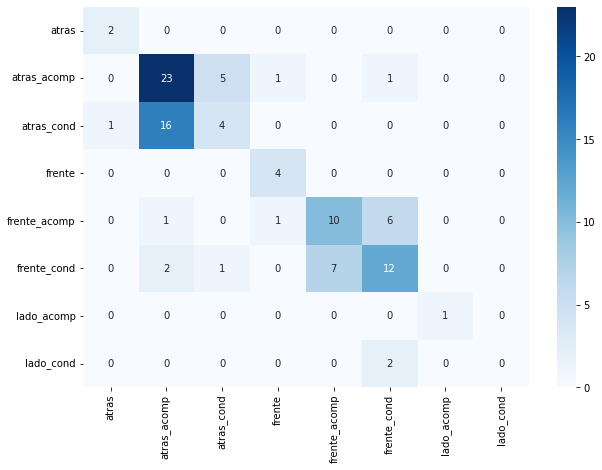

In [209]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(metrics_result['confusion_matrix'], index = classes,
                  columns = classes)

df_cm = df_cm.applymap(lambda x: x.item())

plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap="Blues")
df_cm.to_csv('./trained_models/{}/{}/confusion_matrix.csv'.format(MODEL_NAME, EXPERIMENT_NAME))

In [ ]:
a = "si"

if color == "azul":
    print("es azul!")
elif color == "rojo":
    print("es rojo!")
else:
    print("no se qué color es")